In [1]:
from pathlib import Path
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    _HAS_SNS = True
except Exception:
    _HAS_SNS = False


def find_project_root(start=None):
    if start is None:
        start = Path.cwd().resolve()
    for p in [start] + list(start.parents):
        if (p / "data").exists():
            return p
    return start


PROJECT_ROOT = find_project_root()
DATA_INTERIM = PROJECT_ROOT / "data" / "interim"
PROJECT_ROOT, DATA_INTERIM


(PosixPath('/home/lluis/master-thesis/CSISD'),
 PosixPath('/home/lluis/master-thesis/CSISD/data/interim'))

In [2]:

FEATURE_GLOB = "*/features/*svara_features.parquet"

ID_COLS = {
    "recording_id", "piece_id", "file",
    "svara_id",
    "svara_start_sec", "svara_end_sec", "svara_duration_sec", "svara_n_rows",
}

LABEL_COLS_CANDIDATES = {
    "svara_label", "prev_svara", "next_svara",
    "section_label",
    "svara_lower", "svara_upper",
}

feature_paths = sorted(DATA_INTERIM.glob(FEATURE_GLOB))
len(feature_paths), feature_paths[:5]

(5,
 [PosixPath('/home/lluis/master-thesis/CSISD/data/interim/srs_v1_bdn_sav/features/srs_v1_bdn_sav_svara_features.parquet'),
  PosixPath('/home/lluis/master-thesis/CSISD/data/interim/srs_v1_drn_sav/features/srs_v1_drn_sav_svara_features.parquet'),
  PosixPath('/home/lluis/master-thesis/CSISD/data/interim/srs_v1_psn_sav/features/srs_v1_psn_sav_svara_features.parquet'),
  PosixPath('/home/lluis/master-thesis/CSISD/data/interim/srs_v1_rkm_sav/features/srs_v1_rkm_sav_svara_features.parquet'),
  PosixPath('/home/lluis/master-thesis/CSISD/data/interim/srs_v1_svd_sav/features/srs_v1_svd_sav_svara_features.parquet')])

In [3]:
#current working directory
Path.cwd()
#go to project root
#Path.cwd().parent.parent
project_root = find_project_root()
import sys
sys.path.append(str(project_root))
from src.io.pitch_io import load_pitch_file

In [18]:
from src.io.pitch_io import load_pitch_file

for preprocessed_path in feature_paths[:1]:
    df = pl.read_parquet(preprocessed_path)
    print("PARQUET has section_id?", "section_id" in df.columns)

    df2 = load_pitch_file(preprocessed_path)
    print("LOADER has section_id?", "section_id" in df2.columns)

PARQUET has section_id? False
LOADER has section_id? False


In [5]:
# Carrega i concatena (scan_parquet)

if len(feature_paths) == 0:
    raise FileNotFoundError(
        f"No he trobat parquets amb el patró {FEATURE_GLOB} dins {DATA_INTERIM}. "
        "Revisa el glob o el directori."
    )

scans = [pl.scan_parquet(p) for p in feature_paths]
df = pl.concat(scans, how="vertical_relaxed").collect()
df.shape, df.columns[:20]


((2760, 21),
 ['recording_id',
  'svara_id',
  'svara',
  'svara_start_sec',
  'svara_end_sec',
  'svara_duration_sec',
  'svara_n_rows',
  'duration_sec',
  'pitch_mean',
  'pitch_median',
  'pitch_std',
  'pitch_range',
  'slope_global',
  'd1_mean',
  'd1_std',
  'd1_abs_mean',
  'd1_abs_std',
  'd2_mean',
  'd2_std',
  'd2_abs_mean'])

In [6]:
# Assegura recording_id (si falta, el derivem del path)

if "recording_id" not in df.columns:
    rec_ids = []
    for p in feature_paths:
        # data/interim/<recording_id>/features/...
        parts = p.parts
        if "interim" in parts:
            rid = parts[parts.index("interim") + 1]
        else:
            rid = p.parent.parent.name
        rec_ids.append(rid)

    dfs = []
    for p, rid in zip(feature_paths, rec_ids):
        d = pl.read_parquet(p)
        d = d.with_columns(pl.lit(rid).alias("recording_id"))
        dfs.append(d)

    df = pl.concat(dfs, how="vertical_relaxed")

df.select(["recording_id"]).head()


recording_id
str
"""srs_v1_bdn_sav"""
"""srs_v1_bdn_sav"""
"""srs_v1_bdn_sav"""
"""srs_v1_bdn_sav"""
"""srs_v1_bdn_sav"""


In [7]:
# Identifica features automàticament

present_id_cols = [c for c in ID_COLS if c in df.columns]
present_label_cols = [c for c in LABEL_COLS_CANDIDATES if c in df.columns]

numeric_cols = [c for c, dt in zip(df.columns, df.dtypes) if dt.is_numeric()]
numeric_features = [c for c in numeric_cols if c not in set(present_id_cols) | set(present_label_cols)]

summary = {
    "n_rows": df.height,
    "n_cols": df.width,
    "n_recordings": df.select(pl.col("recording_id").n_unique()).item(),
    "n_id_cols_present": len(present_id_cols),
    "n_label_cols_present": len(present_label_cols),
    "n_numeric_features": len(numeric_features),
}
summary


{'n_rows': 2760,
 'n_cols': 21,
 'n_recordings': 5,
 'n_id_cols_present': 6,
 'n_label_cols_present': 0,
 'n_numeric_features': 14}

In [8]:
# Recompte per recording

counts_by_rec = (
    df.group_by("recording_id")
      .agg(pl.len().alias("n_segments"))
      .sort("n_segments", descending=True)
)
counts_by_rec


recording_id,n_segments
str,u32
"""srs_v1_bdn_sav""",581
"""srs_v1_drn_sav""",578
"""srs_v1_svd_sav""",570
"""srs_v1_psn_sav""",530
"""srs_v1_rkm_sav""",501


In [9]:
# Recompte per svara (si existeix)

if "svara" in df.columns:
    counts_by_svara_label = (
        df.group_by("svara")
          .agg(pl.len().alias("n_segments"))
          .sort("n_segments", descending=True)
    )
    display(counts_by_svara_label)
else:
    print("No hi ha columna 'svara' al parquet (encara).")



svara,n_segments
str,u32
"""D""",616
"""R""",471
"""P""",470
"""S""",401
"""M""",345
"""N""",247
"""G""",210


In [10]:
# Missingness (NaNs + nulls) per feature

if len(numeric_features) == 0:
    print("No hi ha features numèriques detectades.")
else:
    miss = df.select([
        (pl.col(c).is_null().sum() + pl.col(c).is_nan().sum()).alias(c)
        for c in numeric_features
    ]).to_dicts()[0]

    miss_df = (
        pl.DataFrame({
            "feature": list(miss.keys()),
            "missing_count": list(miss.values()),
        })
        .with_columns((pl.col("missing_count") / df.height).alias("missing_frac"))
        .sort("missing_frac", descending=True)
    )

    display(miss_df.head(20))


feature,missing_count,missing_frac
str,i64,f64
"""slope_global""",70,0.025362
"""duration_sec""",66,0.023913
"""pitch_mean""",66,0.023913
"""pitch_median""",66,0.023913
"""pitch_std""",66,0.023913
…,…,…
"""d1_abs_std""",66,0.023913
"""d2_mean""",66,0.023913
"""d2_std""",66,0.023913


In [11]:
# Features constants (variança 0)

if len(numeric_features) > 0:
    var_map = df.select([pl.col(c).var().alias(c) for c in numeric_features]).to_dicts()[0]

    var_df = (
        pl.DataFrame({"feature": list(var_map.keys()), "variance": list(var_map.values())})
        .sort("variance")
    )

    display(var_df.head(20))


feature,variance
str,f64
"""duration_sec""",NaN
"""pitch_mean""",NaN
"""pitch_median""",NaN
"""pitch_std""",NaN
"""pitch_range""",NaN
…,…
"""d1_abs_std""",NaN
"""d2_mean""",NaN
"""d2_std""",NaN


In [12]:
# Duplicats (recording_id, svara_id)

if "recording_id" in df.columns and "svara_id" in df.columns:
    dup = (
        df.group_by(["recording_id", "svara_id"])
          .agg(pl.len().alias("n"))
          .filter(pl.col("n") > 1)
          .sort("n", descending=True)
    )
    if dup.height == 0:
        print("OK: no hi ha duplicats (recording_id, svara_id).")
    else:
        print("ATENCIÓ: hi ha duplicats!")
        dup.head(20)
else:
    print("No puc comprovar duplicats: falta recording_id o svara_id.")


OK: no hi ha duplicats (recording_id, svara_id).


{'n_finite': 2760, 'min': 0.04998779296875, 'p05': 0.300018310546875, 'median': 0.35001373291015625, 'p95': 0.7900543212890625, 'max': 2.310150146484375}


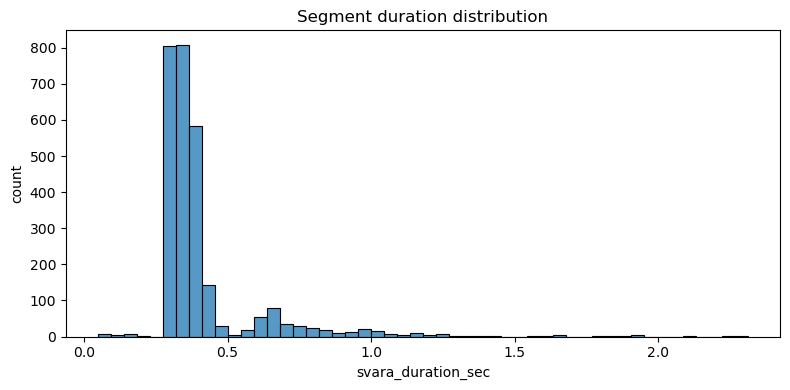

In [13]:
# Distribució de durades de segments

if "svara_duration_sec" in df.columns:
    dur = df["svara_duration_sec"].to_numpy()
    dur = dur[np.isfinite(dur)]

    print({
        "n_finite": int(len(dur)),
        "min": float(np.min(dur)) if len(dur) else np.nan,
        "p05": float(np.quantile(dur, 0.05)) if len(dur) else np.nan,
        "median": float(np.median(dur)) if len(dur) else np.nan,
        "p95": float(np.quantile(dur, 0.95)) if len(dur) else np.nan,
        "max": float(np.max(dur)) if len(dur) else np.nan,
    })

    plt.figure(figsize=(8, 4))
    if _HAS_SNS:
        sns.histplot(dur, bins=50)
    else:
        plt.hist(dur, bins=50)
    plt.title("Segment duration distribution")
    plt.xlabel("svara_duration_sec")
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()
else:
    print("No hi ha columna svara_duration_sec")


{'n': 2760, 'min': 0.04998779296875, 'p05': 0.300018310546875, 'median': 0.35001373291015625, 'p95': 0.7900543212890625, 'max': 2.310150146484375}


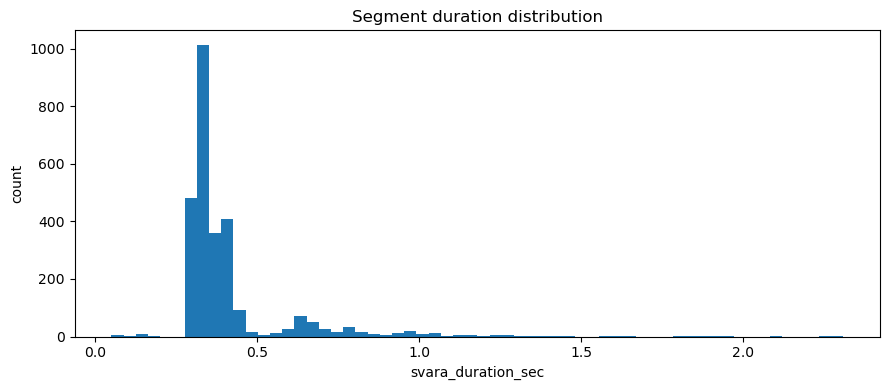

In [14]:
# Histograma de durades (tweakable)

import numpy as np
import matplotlib.pyplot as plt

# --- PARAMETRES (tweak) ---
DUR_COL = "svara_duration_sec"
BINS = 60                  # int o "fd" / "sturges" / "sqrt" / "auto"
RANGE = None               # p.ex. (0, 1.0) per zoom; None = sense
LOG_Y = False              # True si vols veure cues llargues
SHOW_RUG = False           # punts a sota (matplotlib)
DROP_ZERO = True           # treu durades 0 si hi ha errors
CLIP_QUANTILES = None      # p.ex. (0.01, 0.99) per treure outliers visuals

# --- DATA ---
if DUR_COL not in df.columns:
    raise ValueError(f"No hi ha columna {DUR_COL}")

dur = df[DUR_COL].to_numpy()
dur = dur[np.isfinite(dur)]

if DROP_ZERO:
    dur = dur[dur > 0]

if CLIP_QUANTILES is not None and len(dur) > 0:
    qlo, qhi = CLIP_QUANTILES
    lo = np.quantile(dur, qlo)
    hi = np.quantile(dur, qhi)
    dur = dur[(dur >= lo) & (dur <= hi)]

print({
    "n": int(len(dur)),
    "min": float(np.min(dur)) if len(dur) else np.nan,
    "p05": float(np.quantile(dur, 0.05)) if len(dur) else np.nan,
    "median": float(np.median(dur)) if len(dur) else np.nan,
    "p95": float(np.quantile(dur, 0.95)) if len(dur) else np.nan,
    "max": float(np.max(dur)) if len(dur) else np.nan,
})

plt.figure(figsize=(9, 4))
plt.hist(dur, bins=BINS, range=RANGE)
plt.title("Segment duration distribution")
plt.xlabel(DUR_COL)
plt.ylabel("count")
if LOG_Y:
    plt.yscale("log")

if SHOW_RUG and len(dur) > 0:
    y0 = plt.ylim()[0]
    plt.plot(dur, np.full_like(dur, y0), "|")

plt.tight_layout()
plt.show()


Peces plotejades: 5 (MIN_SEGMENTS=20, MAX_PLOTS=12)


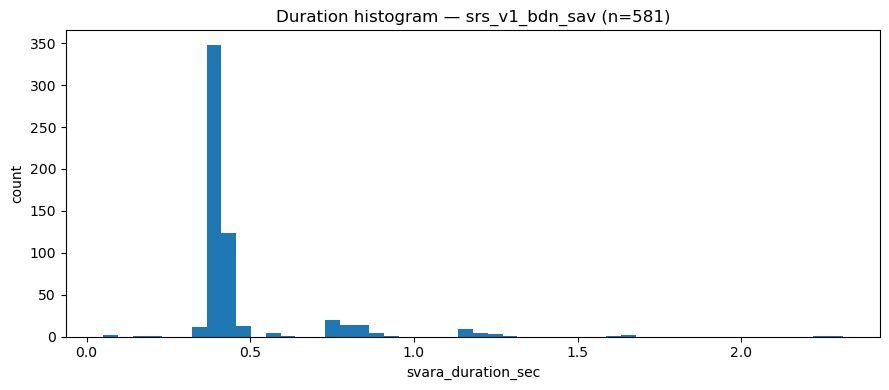

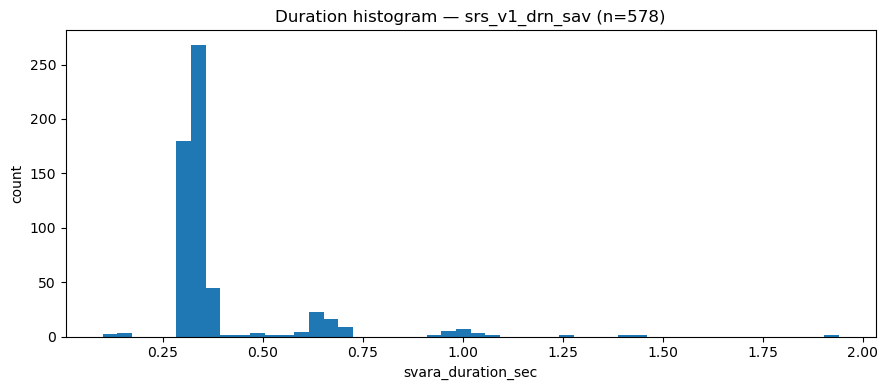

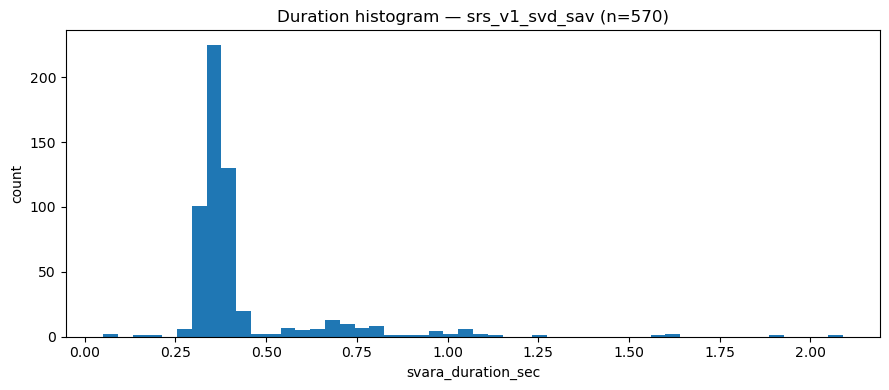

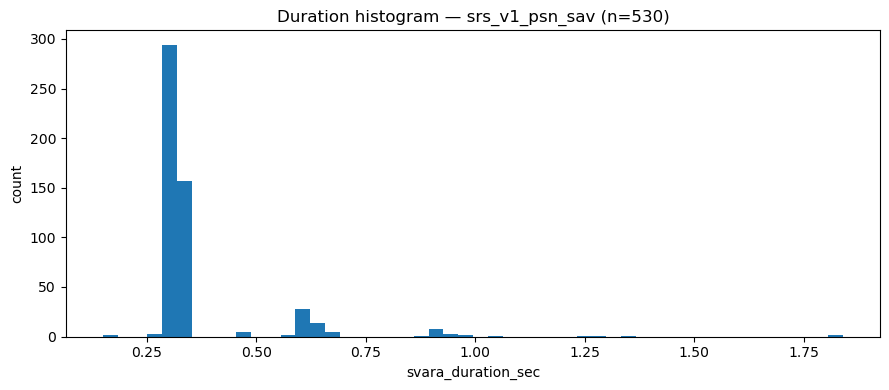

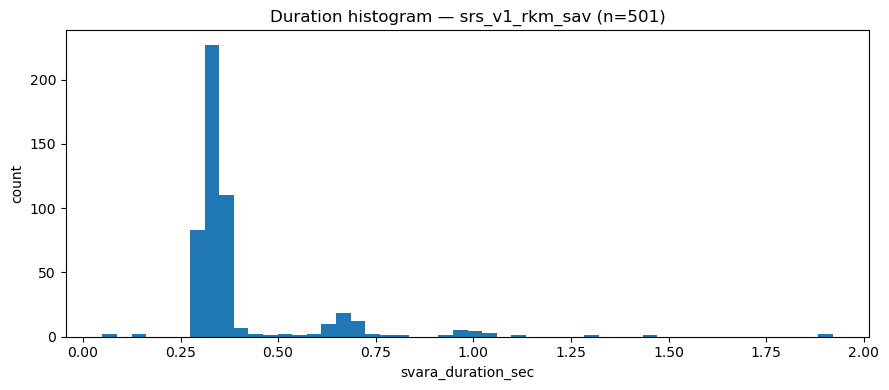

In [15]:
# Histograma per peça (recording_id) amb paràmetres i opció de filtre per nombre mínim de segments

import numpy as np
import matplotlib.pyplot as plt

DUR_COL = "svara_duration_sec"
GROUP_COL = "recording_id"

# --- PARAMETRES (tweak) ---
BINS = 50
RANGE = None               # p.ex. (0, 1.0)
LOG_Y = False
MIN_SEGMENTS = 20          # no plotis peces massa petites
MAX_PLOTS = 12             # limita per no fer 50 figures
ORDER_BY = "n"             # "n" o "median"

if DUR_COL not in df.columns:
    raise ValueError(f"No hi ha columna {DUR_COL}")
if GROUP_COL not in df.columns:
    raise ValueError(f"No hi ha columna {GROUP_COL}")

# resume per peça
summary = (
    df.select([GROUP_COL, DUR_COL])
      .filter(pl.col(DUR_COL).is_not_null())
      .group_by(GROUP_COL)
      .agg([
          pl.len().alias("n"),
          pl.col(DUR_COL).median().alias("median"),
      ])
)

if ORDER_BY == "median":
    summary = summary.sort("median", descending=True)
else:
    summary = summary.sort("n", descending=True)

groups = summary.filter(pl.col("n") >= MIN_SEGMENTS).get_column(GROUP_COL).to_list()
groups = groups[:MAX_PLOTS]

print(f"Peces plotejades: {len(groups)} (MIN_SEGMENTS={MIN_SEGMENTS}, MAX_PLOTS={MAX_PLOTS})")

for rid in groups:
    dur = (
        df.filter(pl.col(GROUP_COL) == rid)
          .select(DUR_COL)
          .to_series()
          .to_numpy()
    )
    dur = dur[np.isfinite(dur)]
    dur = dur[dur > 0]

    plt.figure(figsize=(9, 4))
    plt.hist(dur, bins=BINS, range=RANGE)
    plt.title(f"Duration histogram — {rid} (n={len(dur)})")
    plt.xlabel(DUR_COL)
    plt.ylabel("count")
    if LOG_Y:
        plt.yscale("log")
    plt.tight_layout()
    plt.show()


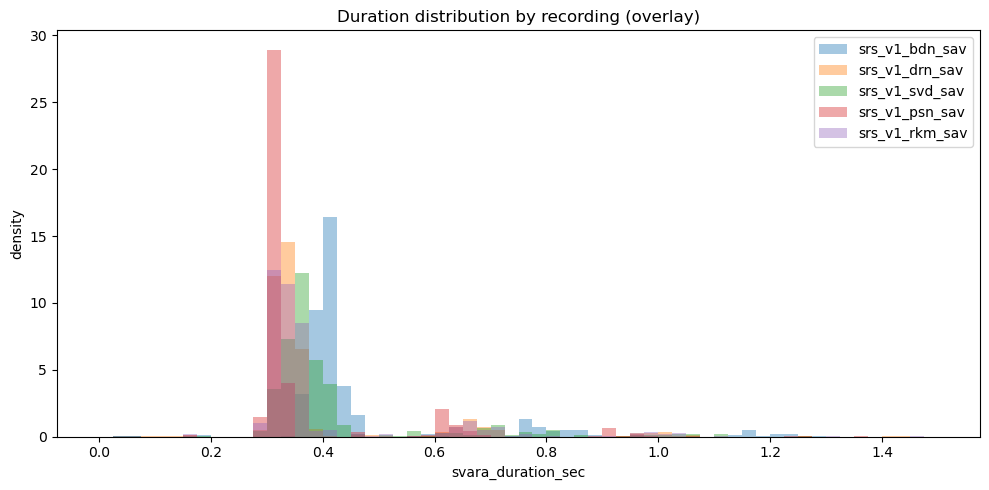

In [16]:
# SALT DE CEL·LA
# Overlay per comparar peces (normalitzat a densitat)

import numpy as np
import matplotlib.pyplot as plt

DUR_COL = "svara_duration_sec"
GROUP_COL = "recording_id"

# --- PARAMETRES (tweak) ---
BINS = 60
RANGE = (0, 1.5)          # habitualment ajuda posar un rang fix per comparar
TOP_K = 6                 # compara les TOP K per n
DENSITY = True            # normalitza a densitat (compara formes)
ALPHA = 0.4

summary = (
    df.select([GROUP_COL, DUR_COL])
      .filter(pl.col(DUR_COL).is_not_null())
      .group_by(GROUP_COL)
      .agg(pl.len().alias("n"))
      .sort("n", descending=True)
)

top = summary.get_column(GROUP_COL).to_list()[:TOP_K]

plt.figure(figsize=(10, 5))
for rid in top:
    dur = (
        df.filter(pl.col(GROUP_COL) == rid)
          .select(DUR_COL)
          .to_series()
          .to_numpy()
    )
    dur = dur[np.isfinite(dur)]
    dur = dur[dur > 0]
    plt.hist(dur, bins=BINS, range=RANGE, density=DENSITY, alpha=ALPHA, label=rid)

plt.title("Duration distribution by recording (overlay)")
plt.xlabel(DUR_COL)
plt.ylabel("density" if DENSITY else "count")
plt.legend()
plt.tight_layout()
plt.show()


In [17]:
# Quick look: top missingness and top variance

if len(numeric_features) > 0:
    print("--- Missingness (top 15) ---")
    if "miss_df" in globals():
        print(miss_df.head(15))

    print("\n--- Variance (top 15) ---")
    if "var_df" in globals():
        print(var_df.sort("variance", descending=True).head(15))


--- Missingness (top 15) ---
shape: (14, 3)
┌──────────────┬───────────────┬──────────────┐
│ feature      ┆ missing_count ┆ missing_frac │
│ ---          ┆ ---           ┆ ---          │
│ str          ┆ i64           ┆ f64          │
╞══════════════╪═══════════════╪══════════════╡
│ slope_global ┆ 70            ┆ 0.025362     │
│ duration_sec ┆ 66            ┆ 0.023913     │
│ pitch_mean   ┆ 66            ┆ 0.023913     │
│ pitch_median ┆ 66            ┆ 0.023913     │
│ pitch_std    ┆ 66            ┆ 0.023913     │
│ …            ┆ …             ┆ …            │
│ d1_abs_std   ┆ 66            ┆ 0.023913     │
│ d2_mean      ┆ 66            ┆ 0.023913     │
│ d2_std       ┆ 66            ┆ 0.023913     │
│ d2_abs_mean  ┆ 66            ┆ 0.023913     │
│ d2_abs_std   ┆ 66            ┆ 0.023913     │
└──────────────┴───────────────┴──────────────┘

--- Variance (top 15) ---
shape: (14, 2)
┌──────────────┬──────────┐
│ feature      ┆ variance │
│ ---          ┆ ---      │
│ str         